# Deep Learning approaches

In [1]:
import pandas as pd
import logging
import torch

from torch.utils.data.dataset import Dataset, T_co
from torch.utils.data import DataLoader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim


from sklearn.metrics import f1_score, accuracy_score

In [4]:
def set_seed(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
from torchmetrics import F1Score
from tqdm import tqdm

In [5]:
set_seed(10)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [100]:
class AlcDataset(Dataset):
    """
    A custom Dataset implementation for our representations of recordings
    from the ALC corpus
    """

    def __init__(self, path, cols, target='alc_x'):
        """
        Builds a torch Dataset containing representations of recordings from
        the ALC corpus


        """
        # load CSV file
        self.df = pd.read_csv(path)
        self.cols = cols
        self.target = target


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> T_co:
        """
        :return: a representation of one recording, and its label

        """
        
        return torch.Tensor(self.df.iloc[index][cols]), self.df.iloc[index][target]

In [101]:
with open('../data/columns.txt') as f:
    cols = f.read().split(', ')[5:]

In [102]:
train_set = AlcDataset('../data/train_set.csv', cols, 'alc')
dev_set = AlcDataset('../data/dev_set.csv', cols, 'alc')
test_set = AlcDataset('../data/test_set.csv', cols, 'alc')

In [103]:
target='alc'

## DataLoader

In [104]:
batch_size=16

In [105]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset=dev_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

## Model Architecture

In [106]:
import torch.nn as nn

In [108]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [110]:
len(cols)

88

In [111]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=len(cols), out_features=60),
#     nn.ReLU(),
    nn.Linear(in_features=60, out_features=30),
    nn.ReLU(),
    nn.Linear(in_features=30, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=88, out_features=60, bias=True)
  (1): Linear(in_features=60, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=1, bias=True)
)

In [112]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.00005)

In [113]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / y_true.shape[0]) * 100 
    return acc

In [114]:
batch_size=16
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset=dev_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
train_dataloader=train_loader
dev_dataloader=dev_loader

In [115]:
from tqdm import tqdm
import numpy as np

In [116]:
torch.manual_seed(42)
epochs = 10

for epoch in tqdm(range(epochs)):
    ### Training
    model_0.train()
    epoch_loss = []
    epoch_metric = []
    for i, (*x, y) in enumerate(train_dataloader,1):
        x=x[0].to(device)
        y=y.type(torch.cuda.FloatTensor)

        y_logits = model_0(x).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
        
    # Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
        loss = loss_fn(y_logits, y) 
        acc = accuracy_fn(y_true=y, y_pred=y_pred) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_metric.append(acc)

    ### Testing
    model_0.eval()
    
    val_loss_list = []
    val_metric_list = []
    with torch.no_grad():
         for i, (*x, y) in enumerate(dev_dataloader):
                
    #with torch.inference_mode():
            x=x[0].to(device)
            y=y.type(torch.cuda.FloatTensor)
            
            test_logits = model_0(x).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits,y)
            test_acc = accuracy_fn(y_true=y,y_pred=test_pred)
            val_loss_list.append(test_loss.item())
            val_metric_list.append(test_acc)
            
    train_loss = np.mean(epoch_loss)
    train_acc = np.mean(epoch_metric)
    val_loss = np.mean(val_loss_list)
    val_acc = np.mean(val_metric_list)
    
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test loss: {val_loss:.5f}, Test acc: {val_acc:.2f}%")

    # Print out what's happening every 10 epochs
#     if epoch % 10 == 0:
          

 10%|████▍                                       | 1/10 [00:12<01:50, 12.23s/it]

Epoch: 0 | Loss: 1.69167, Accuracy: 55.62% | Test loss: 0.87721, Test acc: 63.54%


 20%|████████▊                                   | 2/10 [00:24<01:38, 12.32s/it]

Epoch: 1 | Loss: 0.77392, Accuracy: 58.56% | Test loss: 0.74472, Test acc: 63.05%


 30%|█████████████▏                              | 3/10 [00:37<01:27, 12.44s/it]

Epoch: 2 | Loss: 0.70714, Accuracy: 60.47% | Test loss: 0.68560, Test acc: 62.30%


 40%|█████████████████▌                          | 4/10 [00:50<01:15, 12.62s/it]

Epoch: 3 | Loss: 0.69159, Accuracy: 61.09% | Test loss: 0.75474, Test acc: 45.53%


 50%|██████████████████████                      | 5/10 [01:02<01:03, 12.72s/it]

Epoch: 4 | Loss: 0.67586, Accuracy: 61.89% | Test loss: 0.67168, Test acc: 62.51%


 60%|██████████████████████████▍                 | 6/10 [01:15<00:50, 12.70s/it]

Epoch: 5 | Loss: 0.67044, Accuracy: 62.11% | Test loss: 0.67318, Test acc: 62.94%


 70%|██████████████████████████████▊             | 7/10 [01:28<00:38, 12.71s/it]

Epoch: 6 | Loss: 0.66362, Accuracy: 62.65% | Test loss: 0.69166, Test acc: 57.54%


 80%|███████████████████████████████████▏        | 8/10 [01:41<00:25, 12.68s/it]

Epoch: 7 | Loss: 0.66120, Accuracy: 62.97% | Test loss: 0.70347, Test acc: 63.91%


 90%|███████████████████████████████████████▌    | 9/10 [01:53<00:12, 12.52s/it]

Epoch: 8 | Loss: 0.65785, Accuracy: 63.81% | Test loss: 0.66425, Test acc: 64.00%


100%|███████████████████████████████████████████| 10/10 [02:05<00:00, 12.55s/it]

Epoch: 9 | Loss: 0.65482, Accuracy: 63.99% | Test loss: 0.68356, Test acc: 57.28%


In [117]:
x.shape

torch.Size([12, 88])

In [118]:
y.shape

torch.Size([12])

In [119]:
model_0.eval()

test_metric_list = []
all_preds = []
all_correct = []
with torch.inference_mode():
    for i, (*x, y) in enumerate(test_loader):
                
            x=x[0].to(device)
            y=y.type(torch.cuda.FloatTensor)
            
            test_logits = model_0(x).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy_fn(y_true=y,y_pred=test_pred)
            val_metric_list.append(test_acc)
            all_preds.extend(list(test_pred.to('cpu').numpy()))
            all_correct.extend(list((y.to('cpu').numpy())))
    test_acc = np.mean(val_metric_list)

In [120]:
from functions_for_ML_experiments import cls_alg, visualize, count_metrics

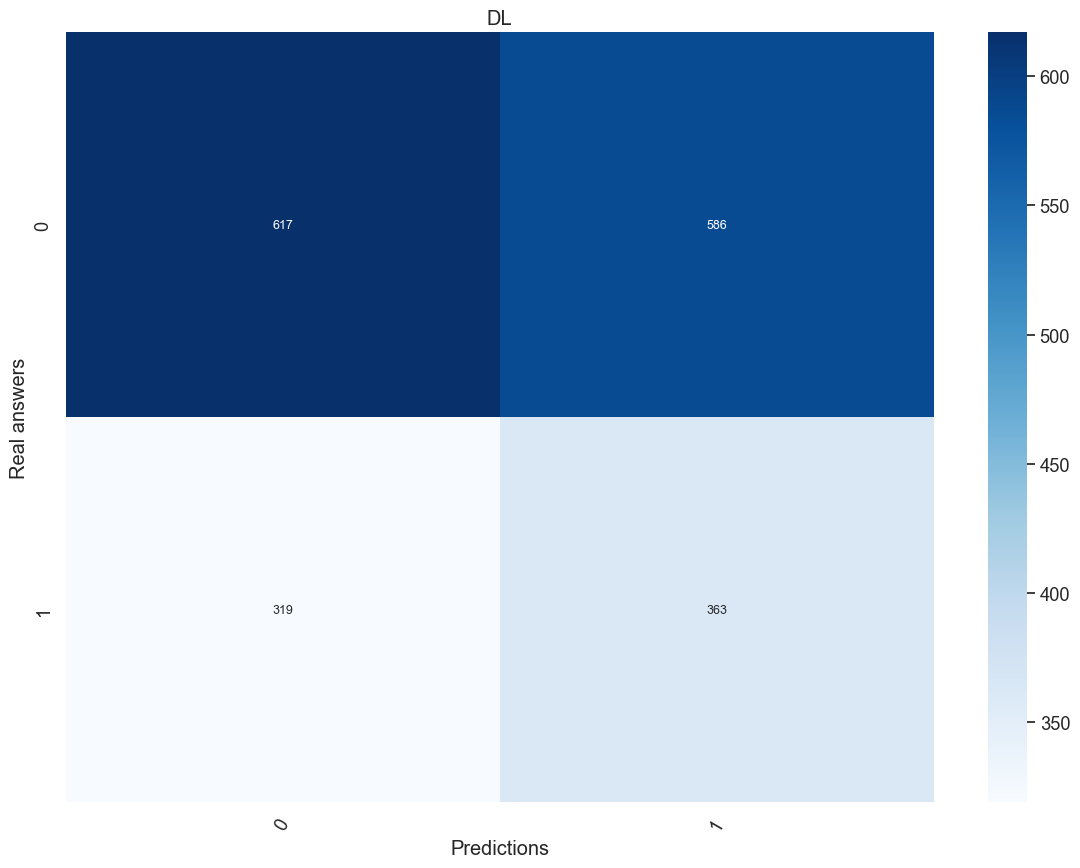

In [59]:
visualize(all_correct,
          all_preds,
          labels_sorted=[0,1],
          algorithm='DL',
          image_path='../experiments_test')

In [60]:
import shap

In [64]:
train_df = pd.read_csv('../data/train_set.csv')
dev_df = pd.read_csv('../data/dev_set.csv')
test_df = pd.read_csv('../data/test_set.csv')
with open('../data/columns.txt') as f:
    feature_cols = f.read().split(', ')[5:]

In [135]:
data = test_df[feature_cols][:100].to_numpy(dtype=np.float32)

In [136]:
f = lambda x: model_0.to('cpu')( Variable( torch.from_numpy(x) ) ).detach().numpy()

In [137]:
import torch
from torch.autograd import Variable
import shap
import numpy
import pandas

torch.set_grad_enabled(False)

In [138]:
explainer = shap.KernelExplainer(f, data)

  0%|          | 0/100 [00:00<?, ?it/s]

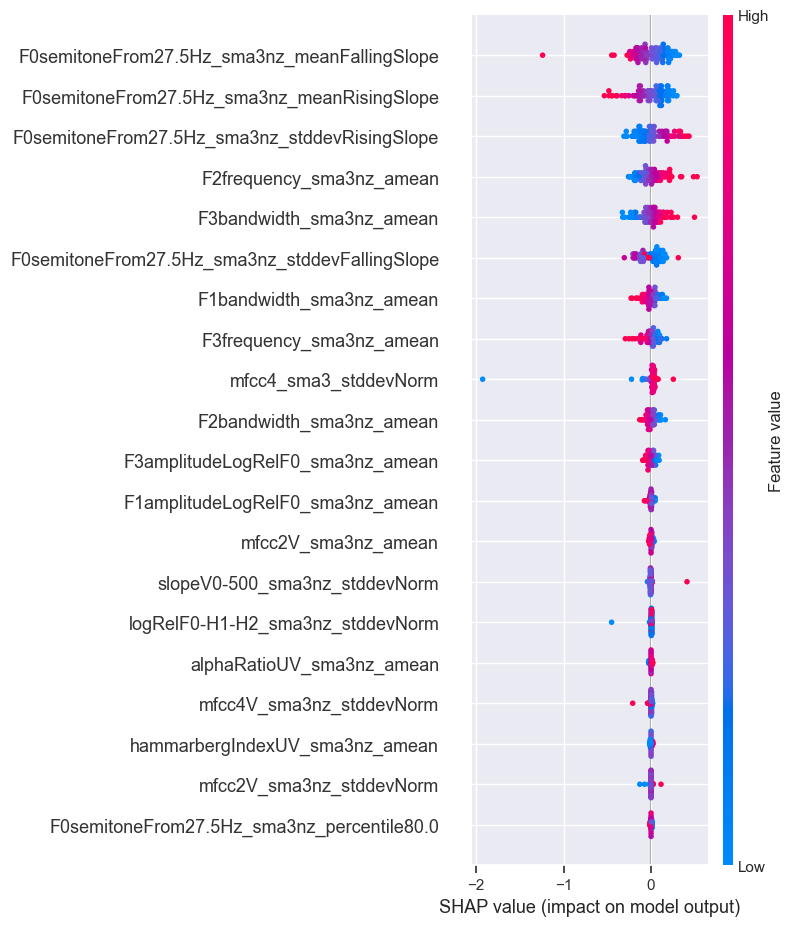

In [139]:
shap_values = explainer.shap_values(data)

# Enable the plots in jupyter
shap.initjs()

feature_names = feature_cols
# Plots
#shap.force_plot(explainer.expected_value, shap_values[0], feature_names)
#shap.dependence_plot("b1_price_avg", shap_values[0], data, feature_names)
shap.summary_plot(shap_values[0], data, feature_names)

## Training Functions

In [ ]:
def train(train_dataloader, dev_dataloader,
          model, optimizer,
          criterion, epochs,
          metric, scheduler=None,
          device=device, verbose=False):

    print('Training...')
    model.train()
    model.to(device)

    losses = []
    val_losses = []
    f1s = []
    val_f1s = []

    #COMMENT first hidden layer initialization - do I need it?
    hidden = torch.zeros(16, 89).to(device)

#     print('init, hidden', hidden.shape)
    for epoch in tqdm(range(epochs)):

        epoch_loss = []
        epoch_metric = []

        if verbose:
            progress_bar = tqdm(total=len(train_dataloader.dataset), desc='Epoch {}'.format(epoch + 1))


        for i, (*x, y) in enumerate(train_dataloader,1):
            x=x[0].to(device)
            optimizer.zero_grad()

            preds, hidden = model(x, hidden)
        

            preds = preds.squeeze(1)    # squeeze dimension and convert boolean label to float
            preds = preds.float()

            y = y.float()
            y = y.to(device)

            loss = criterion(preds, y)

            loss.backward(retain_graph=True)
            optimizer.step()

            epoch_loss.append(loss.item())
            print(preds.shape, y.shape)
            batch_metric = metric(
                preds.round().long(),
                y.long())
            epoch_metric.append(batch_metric.cpu().numpy())

            if verbose:
                progress_bar.update(y.shape[0])

        losses.extend(epoch_loss)
        f1s.extend(epoch_metric)

        print(f'Epoch {epoch+1}:')
        print(f'Train loss: {np.mean(epoch_loss)}, Train metric: {np.mean(epoch_metric)}')
        val_loss, val_metric = evaluate(dev_dataloader, model, criterion, metric, device)
        print('* * ' * 10)

        val_losses.extend(val_loss)
        val_f1s.extend(val_metric)

        model.train()
        if scheduler:
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(np.mean(val_loss))
            else:
                scheduler.step()

    return losses, val_losses, f1s, val_f1s

In [ ]:
def evaluate(dataloader, model, criterion, metric, device=device):

    epoch_loss = []
    epoch_metric = []
    model.eval()

    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):

            preds = model(*x)

            loss = criterion(preds, y)

            epoch_loss.append(loss.item())
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            #batch_metric = metric(preds, y, ignore_index=0)

            epoch_metric.append(batch_metric.cpu().numpy())

    print(f'Val loss: {np.mean(epoch_loss)}, Val metric: {np.mean(epoch_metric)}')

    return epoch_loss, epoch_metric

In [ ]:
import matplotlib.pyplot as plt


def plot_training(train_loss, train_metric, val_loss, val_metric):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(train_loss, label='loss')
    axs[0].plot(train_metric, label='f1')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_title('Train')

    axs[1].plot(val_loss, label='loss')
    axs[1].plot(val_metric, label='f1')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title('Val')
